# Libraries trying to implement graph theory

In [0]:
!pip install assertpy
!pip install igraph

  Running setup.py bdist_wheel for assertpy ... - done
  Stored in directory: /root/.cache/pip/wheels/5c/a7/2b/c043ef2a582b7f9e0f4b85efd9d3baa2254f00aca7430033dc
Successfully built assertpy
    100% |████████████████████████████████| 122kB 2.0MB/s 


In [0]:
!pip uninstall igraph

!pip install python-igraph

Uninstalling igraph-0.1.11:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/igraph-0.1.11.dist-info/*
    /usr/local/lib/python3.6/dist-packages/igraph/*
Proceed (y/n)? y
  Successfully uninstalled igraph-0.1.11
    100% |████████████████████████████████| 378kB 4.6MB/s 
  Running setup.py bdist_wheel for python-igraph ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ |

## Test of some of the libraries

In [0]:
from assertpy import assert_that
import igraph
import pytest
from itertools import combinations


In [0]:
'''
from color import NotPlanarError
from color import make_merge_map
from color import planar_five_color
'''

'\nfrom color import NotPlanarError\nfrom color import make_merge_map\nfrom color import planar_five_color\n'

In [0]:
colors = list(range(5))


class NotPlanarError(Exception):
    pass


def find_two_nonadjacent(graph, nodes):
    """ Return two vertices from nodes that are not adjacent. """
    for x, y in combinations(nodes, 2):
        if not graph.are_connected(x, y):
            return x, y


def planar_five_color(graph):
    """ Color a planar graph with five colors.
    The output is produced by setting the 'color' attribute of graph.vs to be
    integers between 0 and 4.
    Arguments:
      graph: an igraph Graph object to color.
    Returns:
      the input graph with its 'color' attribute modified.
    """
    n = len(graph.vs)

    if n <= 5:
        graph.vs['color'] = colors[:n]
        return graph

    deg_at_most5_nodes = graph.vs.select(_degree_le=5)
    deg_at_most4_nodes = deg_at_most5_nodes.select(_degree_le=4)
    deg5_nodes = deg_at_most5_nodes.select(_degree_eq=5)

    if not deg5_nodes:
        raise ValueError("Input graph (or recursive subgraph) does not "
                         "have a degree 5 node. Input graph is not planar.")

    g_prime = graph.copy()
    # preserved when deleting vertices
    g_prime.vs['old_index'] = list(range(n))

    if len(deg_at_most4_nodes) > 0:
        v = deg_at_most4_nodes[0]
        g_prime.delete_vertices(v.index)
    else:
        v = deg5_nodes[0]
        neighbor_indices = [
            x['old_index'] for x in g_prime.vs[v.index].neighbors()
        ]

        g_prime.delete_vertices(v.index)
        neighbors_in_g_prime = g_prime.vs.select(old_index_in=neighbor_indices)

        result = find_two_nonadjacent(g_prime, neighbors_in_g_prime)
        if not result:
            raise NotPlanarError("Unable to find two nonadjacent vertices "
                                 "for recursive call. Input graph is not planar.")

        w1, w2 = result
        merge_two(g_prime, w1, w2)

    colored_g_prime = planar_five_color(g_prime)

    for w in colored_g_prime.vs:
        # subset selection handles the merged w1, w2 with one assignment
        graph.vs[w['old_index']]['color'] = w['color']

    neighbor_colors = set(w['color'] for w in v.neighbors())
    v['color'] = [j for j in colors if j not in neighbor_colors][0]
    return graph


def make_merge_map(G, w1, w2):
    """ Make a list to denote the merging of two vertices.
    The list "maps" the indices of vertices in the unmerged graph to the
    indices of the vertices in the merged graph.
    For example, merging vertices 2 and 4 might consist of the list
    [1, 2, 0, 3, 0, 4, 5] or [0, 1, 2, 3, 2, 4, 5], i.e., index i of the
    list is the "old index" and the value is the new index, but it doesn't
    matter which new indices you choose, just which vertices are mapped to
    the same index.
    """
    n = len(G.vs)
    no_offset = list(range(w2.index))
    offset_part = [w1.index] + [w2.index + j for j in range(n - w2.index - 1)]
    return no_offset + offset_part


def merge_two(graph, w1, w2):
    """ Merge the two input vertices in the input graph.
    Note this mutates the input graph, so the caller is responsible for making a copy.
    """
    merge_map = make_merge_map(graph, w1, w2)
    graph.contract_vertices(merge_map, combine_attrs=(lambda x: x))


In [0]:
def improperly_colored(G, e):
    return G.vs[e.source]['color'] == G.vs[e.target]['color']


def properly_colored(G):
    return 0 == sum(1 for e in G.es if improperly_colored(G, e))


def test_five_node_empty_graph():
    G = igraph.Graph(n=5)
    planar_five_color(G)
    assert_that(G.vs['color']).is_equal_to([0, 1, 2, 3, 4])


def test_three_node_empty_graph():
    G = igraph.Graph(n=3)
    planar_five_color(G)
    assert_that(G.vs['color']).is_equal_to([0, 1, 2])


def test_color_with_degree_four_node():
    G = igraph.Graph.Full(n=6)
    G.delete_edges([(0, 1)])
    assert_that(G.degree(0)).is_equal_to(4)

    planar_five_color(G)
    assert_that(properly_colored(G)).is_true()


def test_merge_map():
    G = igraph.Graph.Full(n=6)
    w1 = G.vs[1]
    w2 = G.vs[3]
    actual_merged_map = make_merge_map(G, w1, w2)
    assert_that(actual_merged_map).is_equal_to([0, 1, 2, 1, 3, 4])


def test_color_five_regular_planar_graph():
    G = igraph.Graph(n=12)
    flower = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5),
              (1, 2), (1, 5), (1, 6), (1, 7),
              (2, 3), (2, 7), (2, 8),
              (3, 4), (3, 8), (3, 9),
              (4, 5), (4, 9), (4, 10),
              (5, 6), (5, 10),
              (6, 7), (6, 10), (6, 11),
              (7, 8), (7, 11),
              (8, 9), (8, 11),
              (9, 10), (9, 11),
              (10, 11)]

    G.add_edges(flower)
    planar_five_color(G)
    assert_that(properly_colored(G)).is_true()


def test_failure_of_deg_5_node():
    G = igraph.Graph.Full(n=7)
    with pytest.raises(ValueError):
        planar_five_color(G)


def test_failure_of_recursive_call():
    G = igraph.Graph.Full(n=7)
    G.delete_edges([(0, 1)])  # leaves node 0 with deg 5
    with pytest.raises(NotPlanarError):
        planar_five_color(G)

# book programing computer vision with python

In [0]:
#from pygraph.classes.digraph import digraph
#from pygraph.algorithms.minmax import maximum_flow

!pip install pygraph

#!pip install git+https://github.com/jciskey/pygraph

import pygraph

  Stored in directory: /root/.cache/pip/wheels/c7/c1/c1/7375b975d2874461ddd07ad70937e05e4068152c74acf12ce4
Successfully built pygraph


SyntaxError: ignored

In [0]:
!easy_install pygraph

Searching for pygraph
Reading https://pypi.org/simple/pygraph/
Best match: PyGraph 0.2.1
Processing PyGraph-0.2.1.tar.gz
Writing /tmp/easy_install-vDlf0i/PyGraph-0.2.1/setup.cfg
Running PyGraph-0.2.1/setup.py -q bdist_egg --dist-dir /tmp/easy_install-vDlf0i/PyGraph-0.2.1/egg-dist-tmp-v8qIAx
zip_safe flag not set; analyzing archive contents...
Moving PyGraph-0.2.1-py2.7.egg to /usr/local/lib/python2.7/dist-packages
Adding PyGraph 0.2.1 to easy-install.pth file

Installed /usr/local/lib/python2.7/dist-packages/PyGraph-0.2.1-py2.7.egg
Processing dependencies for pygraph
Finished processing dependencies for pygraph


In [0]:
import pygraph

SyntaxError: ignored

In [0]:
gr = digraph()

gr.add_nodes([0,1,2,3])
gr.add_edge((0,1),wt=4)
gr.add_edge((1,2),wt=3)
gr.add_edge((2,3),wt=5)
gr.add_edge((0,2),wt=3)
gr.add_edge((1,3),wt=4)

flows,cuts = maximum_flow(gr,0,3)
print('flow is:', flows)
print('cut is:', cuts)

In [0]:
!pip install python-graph-core

  Stored in directory: /root/.cache/pip/wheels/1f/ce/47/015c1a3e54c2aa5dacd136a7da232a923658774fb7a0f7b4a7
Successfully built python-graph-core


In [0]:
graph = { "a" : ["c"],
          "b" : ["c", "e"],
          "c" : ["a", "b", "d", "e"],
          "d" : ["c"],
          "e" : ["c", "b"],
          "f" : []
        }


In [0]:
def generate_edges(graph):
    edges = []
    for node in graph:
        for neighbour in graph[node]:
            edges.append((node, neighbour))

    return edges
  

def find_isolated_nodes(graph):
    """ returns a list of isolated nodes. """
    isolated = []
    for node in graph:
        if not graph[node]:
            isolated += node
    return isolated
  
def is_connected(self, 
                 vertices_encountered = None, 
                 start_vertex=None):
    """ determines if the graph is connected """
    if vertices_encountered is None:
        vertices_encountered = set()
    gdict = self.__graph_dict        
    vertices = list(gdict.keys()) # "list" necessary in Python 3 
    if not start_vertex:
        # chosse a vertex from graph as a starting point
        start_vertex = vertices[0]
    vertices_encountered.add(start_vertex)
    if len(vertices_encountered) != len(vertices):
        for vertex in gdict[start_vertex]:
            if vertex not in vertices_encountered:
                if self.is_connected(vertices_encountered, vertex):
                    return True
    else:
        return True
    return False

  

In [0]:
print(generate_edges(graph))


[('a', 'c'), ('b', 'c'), ('b', 'e'), ('c', 'a'), ('c', 'b'), ('c', 'd'), ('c', 'e'), ('d', 'c'), ('e', 'c'), ('e', 'b')]


## Pure python implementation from sctarch

In [0]:
class Graph(object):

    def __init__(self, graph_dict=None):
        """ initializes a graph object 
            If no dictionary or None is given, 
            an empty dictionary will be used
        """
        if graph_dict == None:
            graph_dict = {}
        self.__graph_dict = graph_dict

    def vertices(self):
        """ returns the vertices of a graph """
        return list(self.__graph_dict.keys())

    def edges(self):
        """ returns the edges of a graph """
        return self.__generate_edges()

    def add_vertex(self, vertex):
        """ If the vertex "vertex" is not in 
            self.__graph_dict, a key "vertex" with an empty
            list as a value is added to the dictionary. 
            Otherwise nothing has to be done. 
        """
        if vertex not in self.__graph_dict:
            self.__graph_dict[vertex] = []

    def add_edge(self, edge):
        """ assumes that edge is of type set, tuple or list; 
            between two vertices can be multiple edges! 
        """
        edge = set(edge)
        (vertex1, vertex2) = tuple(edge)
        if vertex1 in self.__graph_dict:
            self.__graph_dict[vertex1].append(vertex2)
        else:
            self.__graph_dict[vertex1] = [vertex2]

    def __generate_edges(self):
        """ A static method generating the edges of the 
            graph "graph". Edges are represented as sets 
            with one (a loop back to the vertex) or two 
            vertices 
        """
        edges = []
        for vertex in self.__graph_dict:
            for neighbour in self.__graph_dict[vertex]:
                if {neighbour, vertex} not in edges:
                    edges.append({vertex, neighbour})
        return edges

    def __str__(self):
        res = "vertices: "
        for k in self.__graph_dict:
            res += str(k) + " "
        res += "\nedges: "
        for edge in self.__generate_edges():
            res += str(edge) + " "
        return res


if __name__ == "__main__":

    g = { "a" : ["d"],
          "b" : ["c"],
          "c" : ["b", "c", "d", "e"],
          "d" : ["a", "c"],
          "e" : ["c"],
          "f" : []
        }


    graph = Graph(g)

    print("Vertices of graph:")
    print(graph.vertices())

    print("Edges of graph:")
    print(graph.edges())

    print("Add vertex:")
    graph.add_vertex("z")

    print("Vertices of graph:")
    print(graph.vertices())
 
    print("Add an edge:")
    graph.add_edge({"a","z"})
    
    print("Vertices of graph:")
    print(graph.vertices())

    print("Edges of graph:")
    print(graph.edges())

    print('Adding an edge {"x","y"} with new vertices:')
    graph.add_edge({"x","y"})
    print("Vertices of graph:")
    print(graph.vertices())
    print("Edges of graph:")
    print(graph.edges())


Vertices of graph:
['a', 'b', 'c', 'd', 'e', 'f']
Edges of graph:
[{'d', 'a'}, {'b', 'c'}, {'c'}, {'d', 'c'}, {'c', 'e'}]
Add vertex:
Vertices of graph:
['a', 'b', 'c', 'd', 'e', 'f', 'z']
Add an edge:
Vertices of graph:
['a', 'b', 'c', 'd', 'e', 'f', 'z']
Edges of graph:
[{'d', 'a'}, {'b', 'c'}, {'c'}, {'d', 'c'}, {'c', 'e'}, {'z', 'a'}]
Adding an edge {"x","y"} with new vertices:
Vertices of graph:
['a', 'b', 'c', 'd', 'e', 'f', 'z', 'x']
Edges of graph:
[{'d', 'a'}, {'b', 'c'}, {'c'}, {'d', 'c'}, {'c', 'e'}, {'z', 'a'}, {'x', 'y'}]


# implementation common points in the rigidity graph Fromation control

## through networkx
- directed graph 
- bearing rigidity matrix,

In [0]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse

import scipy as sp

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


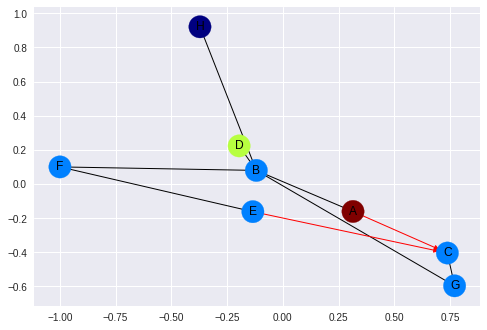

In [10]:
# G = nx.Graph()
# G.add_node(1)
# G.add_nodes_from([2, 3])
# H = nx.path_graph(10)
# G.add_nodes_from(H)
# G.add_node(H)

# Directed Graph


G = nx.DiGraph()
G.add_edges_from(
    [('A', 'B'), ('A', 'C'), ('D', 'B'), ('E', 'C'), ('E', 'F'),
     ('B', 'H'), ('B', 'G'), ('B', 'F'), ('C', 'G')])

val_map = {'A': 1.0,
           'D': 0.5714285714285714,
           'H': 0.0}

values = [val_map.get(node, 0.25) for node in G.nodes()]

# Specify the edges you want here
red_edges = [('A', 'C'), ('E', 'C')]
edge_colours = ['black' if not edge in red_edges else 'red'
                for edge in G.edges()]
black_edges = [edge for edge in G.edges() if edge not in red_edges]


# # Need to create a layout when doing
# # separate calls to draw nodes and edges
# pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
#                        node_color = values, node_size = 500)
# nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
# nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=False)
# plt.show()


### Debugging methods

In [0]:
# important for debuging 

# mainly taken from: https://networkx.github.io/documentation/latest/tutorial.html#creating-a-graph

#print("number of Nodes: ", G.number_of_nodes())
#print("number of Edges: ",G.number_of_edges()) # check the digraph vs undirected graph 



#G.degree[1] # return the degree of the node(vertex) of the value in []
#G[1]  # same as G.adj[1]

#G.edges[1, 2]

#nx.info(G)



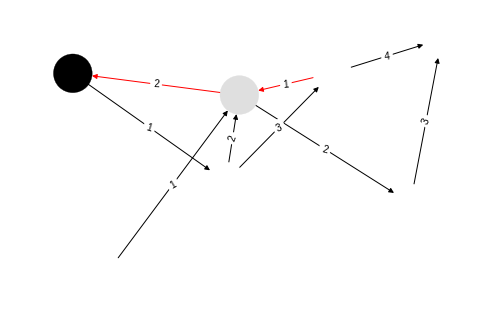

In [12]:
# plot a Directed Graph
# https://stackoverflow.com/questions/20133479/how-to-draw-directed-graphs-using-networkx-in-python#20133763

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab

G = nx.DiGraph()

G.add_edges_from([('A', 'B'),('C','D'),('G','D')], weight=1)
G.add_edges_from([('D','A'),('D','E'),('B','D'),('D','E')], weight=2)
G.add_edges_from([('B','C'),('E','F')], weight=3)
G.add_edges_from([('C','F')], weight=4)


val_map = {'A': 1.0,
           'D': 0.5714285714285714,
           'H': 0.0}

values = [val_map.get(node, 0.45) for node in G.nodes()]
edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
red_edges = [('C','D'),('D','A')]
edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]

pos=nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G,pos, node_color = values, node_size=1500,edge_color=edge_colors,edge_cmap=plt.cm.Reds)
pylab.show()



In [5]:
#@title Adjacancy { form-width: "20%" }

print(G.adj)

# list(G.adj[1])

##### Adjacancy Matrix


##### Adjacancy List

#nx.write_adjlist(G,"test.adjlist")


# for n, nbrs in G.adjacency():
#   print('for the node ', n, ': the C is ', nbrs)
  
# A = nx.adjacency_matrix(G)
# print(A.todense())




{1: {}, 2: {}, 3: {}, 0: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, <networkx.classes.graph.Graph object at 0x7f8a91721b70>: {}}


In [7]:
#@title laplacian { form-width: "20%" }

# there are 2 definitions to define this laplacian matrix 
# L = degree - adjacancy
# L = E*E^T, where E is the Incidence relationship 
# The two Defs. are equivalent, the latter does not depend on the particular
#labeling and orientation chosen for the graph

nx.laplacian_matrix(G)

weight=1
nodelist = G.nodes()
A = nx.to_scipy_sparse_matrix(G, nodelist=nodelist, weight=weight,
                              format='csr')
n,m = A.shape
diags = A.sum(axis=1)
D = scipy.sparse.spdiags(diags.flatten(), [0], m, n, format='csr')
print(D - A) 


#nx.algebraic_connectivity(G)

nx.directed_laplacian_matrix(G)


NetworkXNotImplemented: ignored

In [0]:
## Code sample 
'''
G.add_edge(1, 2, weight=4.7 )
G.add_edges_from([(3, 4), (4, 5)], color='red')
G.add_edges_from([(1, 2, {'color': 'blue'}), (2, 3, {'weight': 8})])
G[1][2]['weight'] = 4.7
G.edges[3, 4]['weight'] = 4.2
G.degree[1]  # the number of edges incident to 1




G.add_edge(1, 2)
H = nx.DiGraph(G)   # create a DiGraph using the connections from G
list(H.edges())

edgelist = [(0, 1), (1, 2), (2, 3)]
H = nx.Graph(edgelist)

#########

FG = nx.DiGraph()
FG.add_weighted_edges_from([(1, 2, 0.125), (1, 3, 0.75), (2, 4, 1.2), (3, 4, 0.375)])
for n, nbrs in FG.adj.items():
   for nbr, eattr in nbrs.items():
       wt = eattr['weight']
       if wt < 1.5: print('(%d, %d, %.3f)' % (n, nbr, wt))

FG.adj.items()
'''



### robot abstract example 

for the paper  https://sic.ici.ro/wp-content/uploads/2012/03/SIC_2012-1-Art1.pdf  decentralized formation control of multi agent robot systems based on formation graphs


In [0]:
p_j = [2 0  0] # belong ot R^3 robot i 3D position in the world

p_j = [2 0  0] # belong ot R^3 robot j 3D position in the world

R_i = [5 0  0] 


In [0]:
# positions in X Y coordinates
P_1= [-5,0]
P_2= [-5,5]
P_3= [-5,0]

# graph initialization 


Laplacian = [[2,-1,-1,0],[-1,1,0,0],[0,-1,1,0],[0,0,-1,0]]

#desired formation position


In [0]:
#This graph is based on the paper : 
#decentralized formation control of multi agent robot systems based on formation graphs

G = nx.DiGraph()
#G.clear
G.add_edges_from([(1, 2),(2, 1), (3, 1),(2, 3), (3,4)])
# G.add_edges_from([(1, 2, {'color': 'blue'}), (2, 3, {'weight': 8})])
G.add_edges_from([(1, 2,{'name': 'c12'}),(2, 1,{'name': 'c21'}), (3, 1,{'name': 'c31'}),(2, 3,{'name': 'c23'}), (3,4,{'name': 'c34'})])



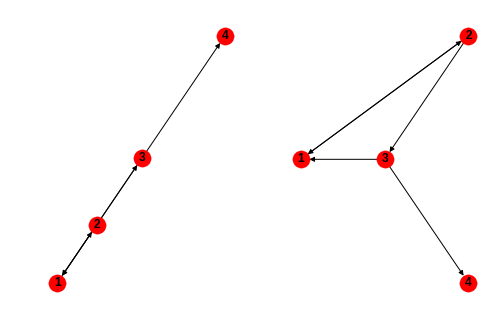

In [0]:
plt.subplot(121)

nx.draw(G, with_labels=True, font_weight='bold')

plt.subplot(122)

nx.draw_shell(G, nlist=[range(1, 5), range(2)], with_labels=True, font_weight='bold')


In [0]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

def draw_graph():
  G = nx . Graph ()
  G . add_edges_from ([(1 ,2) , (2 ,3) , (1 ,3) ,
  (1 ,4) ])
  nx . draw ( G )
  plt . savefig ( " simple_graph . png " )